本节你会构建一个网络，将路透社新闻划分为46个互斥的主题。因为有多个类别，所以这是多分类（multiclass  classification）问题的一个例子。  

因为每个数据点只能划分到一个类别，所以更具体地说，这是单标签、多分类（single-label, multiclass classification）问题的一个例子。  

如果每个数据点可以划分到多个类别（主题），那它就是一个多标签、多分类（multilabel,multiclass classification）问题。

### 3.5.1 The Reuters dataset 路透社数据
它是一个简单的、广泛使用的文本分类数据集。它包括46个不同的主题：某些主题的样本更多，但训练集中每个主题都有至少10个样本

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.datasets import reuters
from tensorflow.keras import losses
from tensorflow.keras import metrics
import matplotlib.pyplot as plt

In [3]:
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(
    num_words=10000)

2113536/2110848 [==============================] - 0s 0us/step


/Users/yihuawang/conda/lib/python3.8/site-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/Users/yihuawang/conda/lib/python3.8/site-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [4]:
len(train_data)

8982

In [5]:
len(test_data)

2246

In [6]:
train_data[10]

[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2979,
 3554,
 14,
 46,
 4689,
 4329,
 86,
 61,
 3499,
 4795,
 14,
 61,
 451,
 4329,
 17,
 12]

In [7]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_newswire = " ".join([reverse_word_index.get(i - 3, "?") for i in
    train_data[0]])

557056/550378 [==============================] - 0s 0us/step


In [10]:
import numpy as np
def vectorize_sequences(sequences, dimension=10000): # 取10,000是因为我们之前限定了10,000个最常见的单词，因此单词索引不会超过10,000
    # 以train_data[0]为例子
    results = np.zeros((len(sequences), dimension)) #产生一个 218* 10,000的矩阵
    for i, sequence in enumerate(sequences): #enumerate() 会产生[(0, 1),(1, 14),...,(217, 32)], 
                                             #前一个数字代表position, 后一个数字代表单词索引
            results[i, sequence] = 1.
    return results
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [11]:
x_train

array([[0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.]])

### Encoding the labels
将标签向量化有两种方法：你可以将标签列表转换为整数张量，或者使用one-hot编码。one-hot编码是分类数据广泛使用的一种格式，也叫分类编码（categorical  encoding）。  

在这个例子中，标签的 one-hot编码就是将每个标签表示为全零向量，只有标签索引对应的元素为 1。其代码实现如下

In [12]:
def to_one_hot(labels, dimension=46): #因为数据集包含46个不同的主题
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results
y_train = to_one_hot(train_labels)
y_test = to_one_hot(test_labels)

In [33]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

### 3.5.3 Building your model 构建网络

Dense层的堆叠，每层只能访问上一层输出的信息。如果某一层丢失了与分类问题相关的一些信息，那么这些信息无法被后面的层找回，也就是说，每一层都可能成为信息瓶颈。上一个例子使用了16维的中间层，但对这个例子来说16维空间可能太小了，无法学会区分46个不同的类别。这种维度较小的层可能成为信息瓶颈，永久地丢失相关信息。  
dense层数一般都是2^n

In [15]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax')) 
# 网络的最后一层是大小为46的Dense层。这意味着，对于每个输入样本，网络都会输出一个46维向量。这个向量的每个元素（即每个维度）代表不同的输出类别
#最后一层使用了 softmax激活。你在MNIST例子中见过这种用法。网络将输出在46个不同输出类别上的概率分布——对于每一个输入样本，
#网络都会输出一个46维向量，其中output[i]是样本属于第i个类别的概率。46个概率的总和为 1。

In [16]:
# 多分类--categorical_crossentropy
model.compile(optimizer='rmsprop',
        loss='categorical_crossentropy',
        metrics=['accuracy'])

### 3.5.4 Validating your approach 验证
同样从训练集中留出1000个作为验证集

In [17]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = y_train[:1000]
partial_y_train = y_train[1000:]

In [18]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
16/16 [==============================] - 1s 58ms/step - loss: 3.2019 - accuracy: 0.4083 - val_loss: 1.8418 - val_accuracy: 0.6060
Epoch 2/20
16/16 [==============================] - 0s 19ms/step - loss: 1.5128 - accuracy: 0.6794 - val_loss: 1.3494 - val_accuracy: 0.7080
Epoch 3/20
16/16 [==============================] - 0s 19ms/step - loss: 1.1048 - accuracy: 0.7580 - val_loss: 1.1489 - val_accuracy: 0.7520
Epoch 4/20
16/16 [==============================] - 0s 18ms/step - loss: 0.8511 - accuracy: 0.8181 - val_loss: 1.0594 - val_accuracy: 0.7750
Epoch 5/20
16/16 [==============================] - 0s 18ms/step - loss: 0.6535 - accuracy: 0.8610 - val_loss: 0.9721 - val_accuracy: 0.7980
Epoch 6/20
16/16 [==============================] - 0s 19ms/step - loss: 0.5268 - accuracy: 0.8890 - val_loss: 0.9180 - val_accuracy: 0.8050
Epoch 7/20
16/16 [==============================] - 0s 20ms/step - loss: 0.4357 - accuracy: 0.9127 - val_loss: 0.8845 - val_accuracy: 0.8140
Epoch 8/20
16

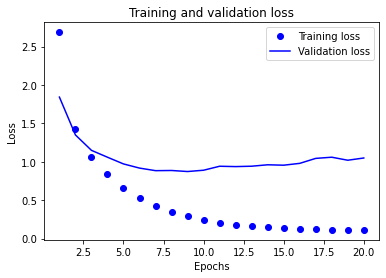

In [19]:
# Plotting the training and validation loss
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

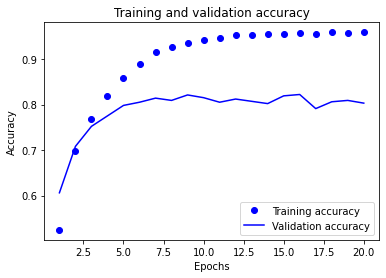

In [20]:
# Plotting the training and validation accuracy
plt.clf()
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

由图可见，网络在训练9轮后开始过拟合，因此我们从头开始训练一个新网络

In [34]:
# Retraining a model from scratch
model = keras.Sequential([
  layers.Dense(64, activation="relu"),
  layers.Dense(64, activation="relu"),
  layers.Dense(46, activation="softmax")
])
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.fit(x_train,
          y_train,
          epochs=9,
          batch_size=512)
results = model.evaluate(x_test, y_test)


Epoch 1/9
18/18 [==============================] - 1s 15ms/step - loss: 3.1356 - accuracy: 0.4042
Epoch 2/9
18/18 [==============================] - 0s 19ms/step - loss: 1.5120 - accuracy: 0.6950
Epoch 3/9
18/18 [==============================] - 0s 19ms/step - loss: 1.0402 - accuracy: 0.7798
Epoch 4/9
18/18 [==============================] - 0s 20ms/step - loss: 0.8158 - accuracy: 0.8282
Epoch 5/9
18/18 [==============================] - 0s 16ms/step - loss: 0.6275 - accuracy: 0.8693
Epoch 6/9
18/18 [==============================] - 0s 19ms/step - loss: 0.5104 - accuracy: 0.8912
Epoch 7/9
18/18 [==============================] - 0s 15ms/step - loss: 0.4131 - accuracy: 0.9131
Epoch 8/9
18/18 [==============================] - 0s 15ms/step - loss: 0.3441 - accuracy: 0.9287
Epoch 9/9
71/71 [==============================] - 0s 1ms/step - loss: 0.9505 - accuracy: 0.7930


In [22]:
# 计算完全随机的精度，大约为18%
import copy
test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
hits_array = np.array(test_labels) == np.array(test_labels_copy)
hits_array.mean()

0.1829919857524488

### 3.5.5 Generating predictions on new data 在新数据上生成预测结果

In [23]:
predictions = model.predict(x_test)

In [26]:
#每个元素都是长度为46的向量
predictions[0].shape

(46,)

In [25]:
#这个向量的所有元素总和为1
np.sum(predictions[0])

1.0000001

In [27]:
#最大的元素就是预测类别，即概率最大的类别
np.argmax(predictions[0])

4

### 3.5.6 A different way to handle the labels and the loss 处理标签和损失的另一种方法
前面提到了另一种编码标签的方法，就是将其转换为整数张量，如下所示。

In [28]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

对于这种编码方法，唯一需要改变的是损失函数的选择。  
原本的损失函数 categorical_crossentropy，标签应该遵循分类编码。  
对于整数标签，你应该使用sparse_categorical_crossentropy。

In [ ]:
model.compile(optimizer='rmsprop',
        loss='sparse_categorical_crossentropy',
        metrics=['acc'])
#这个新的损失函数在数学上与categorical_crossentropy完全相同，二者只是接口不同。

### 3.5.7 The importance of having sufficiently large intermediate layers
中间层维度足够大的重要性

In [29]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))
model.compile(optimizer='rmsprop',
        loss='categorical_crossentropy',
        metrics=['accuracy'])
model.fit(partial_x_train,
        partial_y_train,
        epochs=20,
        batch_size=128,
        validation_data=(x_val, y_val))

Epoch 1/20
63/63 [==============================] - 1s 14ms/step - loss: 3.2789 - accuracy: 0.1416 - val_loss: 2.0881 - val_accuracy: 0.5820
Epoch 2/20
63/63 [==============================] - 1s 10ms/step - loss: 1.7881 - accuracy: 0.6146 - val_loss: 1.5757 - val_accuracy: 0.6010
Epoch 3/20
63/63 [==============================] - 1s 10ms/step - loss: 1.4347 - accuracy: 0.6340 - val_loss: 1.4783 - val_accuracy: 0.6240
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 1.2615 - accuracy: 0.6527 - val_loss: 1.4279 - val_accuracy: 0.6220
Epoch 5/20
63/63 [==============================] - 1s 9ms/step - loss: 1.1276 - accuracy: 0.6780 - val_loss: 1.4198 - val_accuracy: 0.6340
Epoch 6/20
63/63 [==============================] - 1s 9ms/step - loss: 1.0698 - accuracy: 0.6970 - val_loss: 1.4303 - val_accuracy: 0.6420
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 0.9986 - accuracy: 0.7199 - val_loss: 1.4244 - val_accuracy: 0.6670
Epoch 8/20
63/63 

现在网络的验证精度最大约为 71%，比前面下降了 8%。导致这一下降的主要原因在于，你试图将大量信息（这些信息足够恢复 46个类别的分割超平面）压缩到维度很小的中间空间。网络能够将大部分必要信息塞入这个四维表示中，但并不是全部信息。

### 3.5.8　Further experiments 进一步的实验

In [35]:
model = keras.Sequential([
  layers.Dense(64, activation="relu"),
  layers.Dense(64, activation="relu"),
  layers.Dense(64, activation="relu"),
  layers.Dense(64, activation="relu"),
  layers.Dense(46, activation="softmax")
])
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.fit(x_train,
          y_train,
          epochs=9,
          batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/9
18/18 [==============================] - 1s 18ms/step - loss: 3.2489 - accuracy: 0.3385
Epoch 2/9
18/18 [==============================] - 0s 17ms/step - loss: 1.5930 - accuracy: 0.6240
Epoch 3/9
18/18 [==============================] - 0s 16ms/step - loss: 1.1623 - accuracy: 0.7311
Epoch 4/9
18/18 [==============================] - 0s 17ms/step - loss: 0.9234 - accuracy: 0.7885
Epoch 5/9
18/18 [==============================] - 0s 16ms/step - loss: 0.7483 - accuracy: 0.8245
Epoch 6/9
18/18 [==============================] - 0s 17ms/step - loss: 0.5889 - accuracy: 0.8655
Epoch 7/9
18/18 [==============================] - 0s 16ms/step - loss: 0.4830 - accuracy: 0.8901
Epoch 8/9
18/18 [==============================] - 0s 17ms/step - loss: 0.4125 - accuracy: 0.9094
Epoch 9/9
71/71 [==============================] - 1s 1ms/step - loss: 1.1635 - accuracy: 0.7609


In [37]:
model = keras.Sequential([
  layers.Dense(256, activation="relu"),
  layers.Dense(256, activation="relu"),
  layers.Dense(256, activation="relu"),
  layers.Dense(256, activation="relu"),
  layers.Dense(46, activation="softmax")
])
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.fit(x_train,
          y_train,
          epochs=9,
          batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/9
18/18 [==============================] - 1s 44ms/step - loss: 2.7390 - accuracy: 0.3555
Epoch 2/9
18/18 [==============================] - 1s 42ms/step - loss: 1.2133 - accuracy: 0.7145
Epoch 3/9
18/18 [==============================] - 1s 42ms/step - loss: 0.8463 - accuracy: 0.7972
Epoch 4/9
18/18 [==============================] - 1s 47ms/step - loss: 0.6595 - accuracy: 0.8375
Epoch 5/9
18/18 [==============================] - 1s 44ms/step - loss: 0.3738 - accuracy: 0.9103
Epoch 6/9
18/18 [==============================] - 1s 43ms/step - loss: 0.2809 - accuracy: 0.9336
Epoch 7/9
18/18 [==============================] - 1s 43ms/step - loss: 0.1866 - accuracy: 0.9512
Epoch 8/9
18/18 [==============================] - 1s 42ms/step - loss: 0.1925 - accuracy: 0.9497
Epoch 9/9
71/71 [==============================] - 0s 3ms/step - loss: 1.1956 - accuracy: 0.7916
